In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder = 'results_sweep_smass_040122'
run = 'Sage_vlarge_all_4t_z0.0_quantile_raw_vculwx'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    

In [3]:
lows=[]
pred = []
  
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
ys=results['ys']+9
pred=results['pred']+9
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
data_p=config["data_params"]
print(config)

{'experiment': 'GraphMerge', 'group': 'sweep_smass', 'move': False, 'model': 'Sage', 'log': True, 'run_params': {'n_epochs': 250, 'n_trials': 1, 'batch_size': 512, 'val_epoch': 2, 'early_stopping': True, 'patience': 20, 'l1_lambda': 0.0, 'l2_lambda': 0.0, 'loss_func': 'L2', 'metrics': 'test_multi', 'performance_plot': 'SAM_base', 'shuffle': True, 'save': True, 'seed': False, 'num_workers': 4}, 'learn_params': {'learning_rate': 0.001, 'schedule': 'warmup_expcos', 'g_up': 1, 'g_down': 0.95, 'warmup': 4, 'period': 10, 'eta_min': 1e-05}, 'hyper_params': {'hidden_channels': 128, 'conv_layers': 5, 'conv_activation': 'relu', 'decode_activation': 'leakyrelu', 'decode_layers': 2, 'layernorm': True, 'agg': 'sum', 'variance': False, 'rho': 0, 'in_channels': 43, 'out_channels': 1}, 'data_params': {'case': 'vlarge_all_4t_z0.0_quantile_raw', 'targets': [0], 'split': 0.8, 'shuffle': 0}, 'experiment_name': 'lea0.001g_u1.7g_d0.95con5.0dec2.0hid128.0l1_0.0l2_0.0'}


In [4]:
datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{data_p["case"]}/data.pkl'), 'rb'))
from torch_geometric.data import Data
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[[data_p["targets"]]]))

In [5]:
if not data_p["shuffle"]:
    test_data=data[int(len(data)*0.8):]
    train_data=data[:int(len(data)*0.8)]    

In [6]:
Mhf=[]
M200= []
M500 = []
M2500 = []
r_vir = []
rs_klypin = []
for d in test_data:
    Mhf.append(d.x.numpy()[0,3])
    
    r_vir.append(d.x.numpy()[0,4])
    rs_klypin.append(d.x.numpy()[0,20])
    
    M200.append(d.x.numpy()[0,23])
    M500.append(d.x.numpy()[0,24])
    M2500.append(d.x.numpy()[0,25])  
    

In [7]:
transform_path=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphStorage')  
transformer=pickle.load(open(osp.join(transform_path,'transformers','quantile_allfeat_1.pkl'), 'rb'))

In [8]:
Mhf=np.hstack(transformer[10].inverse_transform(np.array(Mhf).reshape(-1,1)))
M200=np.hstack(transformer[40].inverse_transform(np.array(M200).reshape(-1,1)))
M500=np.hstack(transformer[41].inverse_transform(np.array(M500).reshape(-1,1)))
M2500=np.hstack(transformer[42].inverse_transform(np.array(M2500).reshape(-1,1)))

r_vir=np.hstack(transformer[11].inverse_transform(np.array(r_vir).reshape(-1,1)))

rs_klypin=np.hstack(transformer[37].inverse_transform(np.array(rs_klypin).reshape(-1,1)))

In [9]:
rs_klypin

array([4.8178496, 4.3509197, 3.45509  , ..., 3.13683  , 4.75557  ,
       1.84226  ], dtype=float32)

In [10]:
transformer.keys()

dict_keys([0, 2, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [11]:
nbins=25
edges=np.percentile(Mhf, np.linspace(0,100,nbins))
# edges=np.linspace(min(Mhf), max(Mhf),nbins)
centers=(edges[:-1]+edges[1:])/2
sigM=[]
ysigs, predsigs = [], []
yb, predb = [], []
for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)
    ysigs.append(np.std(ys[mask]))
    predsigs.append(np.std(pred[mask]))
    sigM.append(np.std(pred[mask]-ys[mask]))
    yb.append(np.mean(ys[mask]-pred[mask]))
#     predb.append(np.mean(pred[mask]))
    
sigM=np.array(sigM)
ysigs, predsigs = np.array(ysigs), np.array(predsigs)
yb, predb = np.array(yb), np.array(predb)

In [12]:
nbins=10
bin_plot=100
edges1=np.percentile(ys, np.linspace(0,100,nbins))
centers_Ms=(edges1[:-1]+edges1[1:])/2
sigMs=[]
ysig_Ms, predsig_Ms = [], []

ybs, predbs = [], []

for i in range(len(edges1)-1):
    mask=np.logical_and(edges1[i]<=ys,edges1[i+1]>=ys)
    ysig_Ms.append(np.std(ys[mask]))
    predsig_Ms.append(np.std(pred[mask]))
    sigMs.append(np.std(pred[mask]-ys[mask]))
    
    ybs.append(np.mean(ys[mask]))
    predbs.append(np.mean(pred[mask]))
#     fig, ax = plt.subplots()
# #     ax.plot(pred[mask],'o', markersize=2, alpha=0.9, label='Prediction')
# #     ax.plot(ys[mask],'ro', markersize=2, alpha=0.2, label='True')
#     tot=np.hstack([pred[mask], ys[mask]])
#     ax.hist(pred[mask],bins=bin_plot, range=(min(tot), max(tot)),
#                                                   histtype='step', density=1, label='Prediction')
#     ax.hist(ys[mask], bins=bin_plot, range=(min(tot), max(tot)),
#                                      histtype='step', density=1, label='True')
#     ax.vlines(edges1[i], 0,1, 'k')
#     ax.vlines(edges1[i+1], 0,1, 'k')
    
#     ax.set(title=f'Pred sig {np.std(pred[mask]):.3f}, SAM sig {np.std(ys[mask]):.3f}, bin {edges1[i+1]-edges1[i]}')
#     ax.legend()
    
sigMs=np.array(sigMs)
ysig_Ms, predsig_Ms = np.array(ysig_Ms), np.array(predsig_Ms)
ybs, predbs = np.array(ybs),np.array(predbs)

In [13]:
yb, predb

(array([-0.00919535, -0.00233317, -0.00072071,  0.00162644,  0.00245571,
         0.00887486,  0.00874495,  0.00840721,  0.00681618,  0.00424425,
         0.00578974, -0.00015536,  0.00512472,  0.00366646,  0.00035461,
         0.0019275 , -0.00434276, -0.00181315,  0.00086568,  0.00543393,
         0.00296702, -0.00040862, -0.00215496,  0.01068672], dtype=float32),
 array([], dtype=float64))

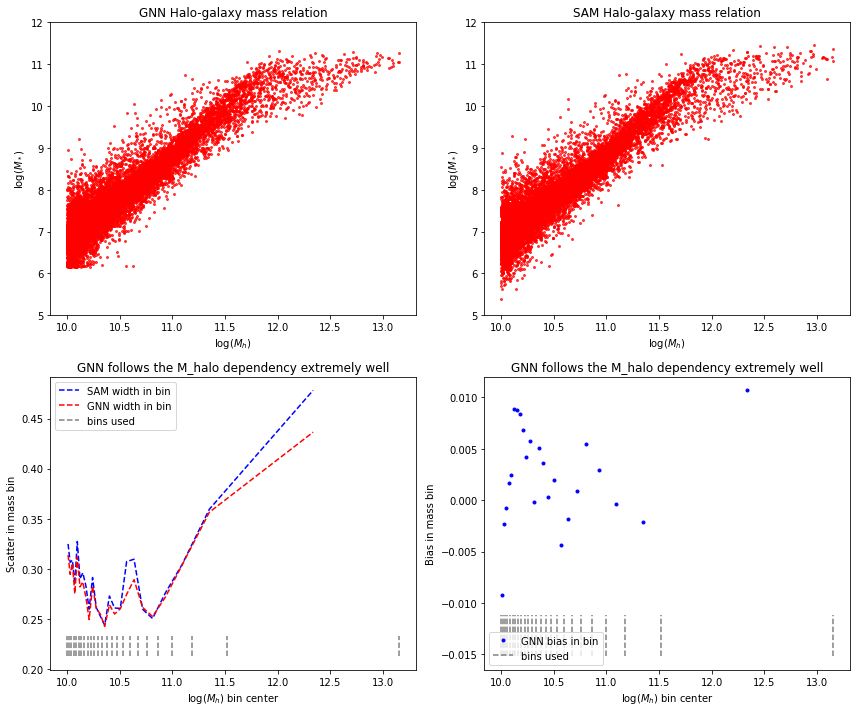

In [14]:
fig, ax =plt.subplots(ncols=2,nrows=2, figsize=(12,10))
ax=ax.flatten()
ax[0].plot(Mhf, pred,'ro', markersize=2, alpha=0.7, label='Prediction')
ax[0].set(xlabel=r'log($M_h$)', ylabel=r'log($M_*$)', title='GNN Halo-galaxy mass relation', ylim=(5,12))
# ax[0].legend(loc='upper left')

ax[1].plot(Mhf, ys,'ro', markersize=2, alpha=0.7, label='True')
ax[1].set(xlabel=r'log($M_h$)', ylabel=r'log($M_*$)', title='SAM Halo-galaxy mass relation', ylim=(5,12))
# ax[1].legend(loc='upper left')

ax[2].vlines(edges, min(predsigs)-0.03, min(predsigs)-0.01, color='gray', linestyle='--', label='bins used')
ax[2].plot(centers, ysigs, 'b--', label='SAM width in bin')
ax[2].plot(centers, predsigs, 'r--', label='GNN width in bin')
ax[2].set(xlabel=r'log($M_h$) bin center', ylabel=r'Scatter in mass bin', title='GNN follows the M_halo dependency extremely well')
ax[2].legend()

ax[3].vlines(edges, min(yb)-0.03/5, min(yb)-0.01/5, color='gray', linestyle='--', label='bins used')
ax[3].plot(centers, yb, 'b.', label='GNN bias in bin')
ax[3].set(xlabel=r'log($M_h$) bin center', ylabel=r'Bias in mass bin', title='GNN follows the M_halo dependency extremely well')
ax[3].legend()

fig.tight_layout()

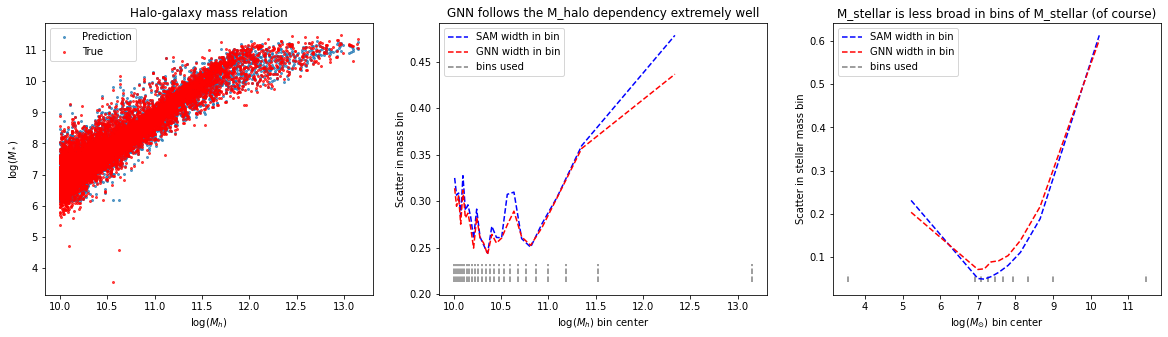

In [15]:
fig, ax =plt.subplots(ncols=3,nrows=1, figsize=(20,5))
ax=ax.flatten()
ax[0].plot(Mhf, pred,'o', markersize=2, alpha=0.7, label='Prediction')
ax[0].plot(Mhf, ys,'ro', markersize=2, alpha=0.7, label='True')
ax[0].set(xlabel=r'log($M_h$)', ylabel=r'log($M_*$)', title='Halo-galaxy mass relation')
ax[0].legend()
ax[1].vlines(edges, min(predsigs)-0.03, min(predsigs)-0.01, color='gray', linestyle='--', label='bins used')
ax[1].plot(centers, ysigs, 'b--', label='SAM width in bin')
ax[1].plot(centers, predsigs, 'r--', label='GNN width in bin')
ax[1].set(xlabel=r'log($M_h$) bin center', ylabel=r'Scatter in mass bin', title='GNN follows the M_halo dependency extremely well')
ax[1].legend()

ax[2].vlines(edges1, min(predsig_Ms)-0.03, min(predsig_Ms)-0.01, color='gray', linestyle='--', label='bins used')
ax[2].plot(centers_Ms, ysig_Ms, 'b--', label='SAM width in bin')
ax[2].plot(centers_Ms, predsig_Ms, 'r--', label='GNN width in bin')
ax[2].set(xlabel=r'log($M_{\odot}$) bin center', ylabel=r'Scatter in stellar mass bin', title='M_stellar is less broad in bins of M_stellar (of course)')
ax[2].legend()

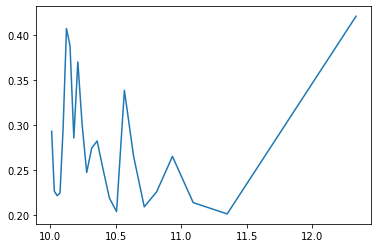

In [16]:
plt.plot( centers, np.array(sigM)/np.array(ysigs))

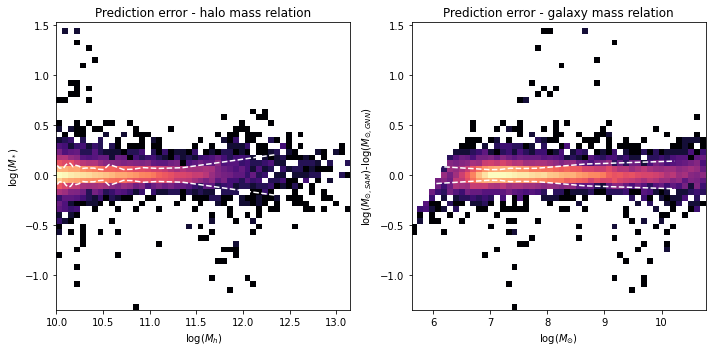

In [17]:
import matplotlib as mpl
bins=50
l=0.02
res=ys.flatten()-pred.flatten()
fig, ax =plt.subplots(ncols=2,nrows=1, figsize=(10,5))
ax=ax.flatten()
ax[0].hist2d(np.array(Mhf), res, bins=bins, range=[np.percentile(Mhf, [0,100]),
            np.percentile(res, [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
ax[0].plot(centers, sigM, 'w--')
ax[0].plot(centers, -sigM, 'w--')

ax[0].set(xlabel=r'log($M_h$)', ylabel=r'log($M_*$)', title='Prediction error - halo mass relation')
# ax[0].legend()
ax[1].hist2d(ys.flatten(), res, bins=bins, range=[np.percentile(ys.flatten(), [l,100-1]),
            np.percentile(res, [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)

ax[1].plot(centers_Ms, sigMs, 'w--')
ax[1].plot(centers_Ms, -sigMs, 'w--')

ax[1].set(xlabel=r'log($M_{\odot}$)', 
          ylabel=r'log($M_{\odot, SAM}$)-log($M_{\odot,GNN}$)', 
          title='Prediction error - galaxy mass relation')
# ax[1].legend()
fig.tight_layout()

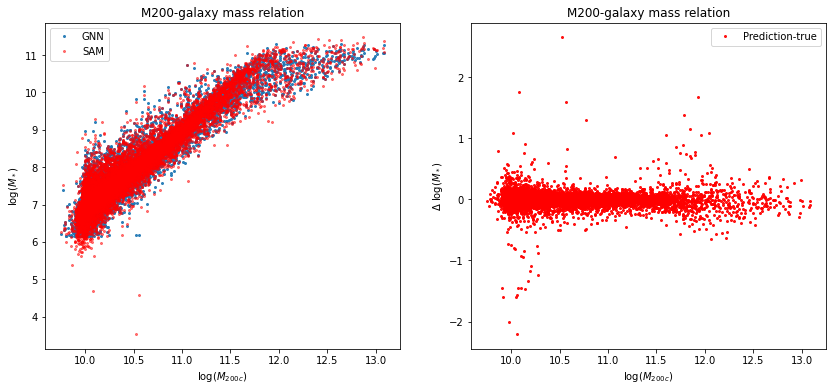

In [18]:
fig, ax =plt.subplots(ncols=2,nrows=1, figsize=(14,6))
ax=ax.flatten()
ax[0].plot(M200, pred,'o', markersize=2, alpha=0.9, label='GNN')
ax[0].plot(M200, ys,'ro', markersize=2, alpha=0.5, label='SAM')
ax[0].set(xlabel=r'log($M_{200c}$)', ylabel=r'log($M_*$)', title='M200-galaxy mass relation')
ax[0].legend()
ax[1].plot(M200, pred-ys,'ro', markersize=2, alpha=0.9, label='Prediction-true')
ax[1].set(xlabel=r'log($M_{200c}$)', ylabel=r'$\Delta$ log($M_*$)', title='M200-galaxy mass relation')
ax[1].legend()

In [19]:
Y=r_vir/rs_klypin

In [20]:
nbins=25
edges=np.percentile(Y, np.linspace(0,100,nbins))
# edges=np.linspace(min(Mhf), max(Mhf),nbins)
centers=(edges[:-1]+edges[1:])/2
deltay=[]
deltapred=[]

for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<Y,edges[i+1]>=Y)
    deltay.append(np.std(ys[mask]-np.mean(ys[mask])))
    deltapred.append(np.std(pred[mask]-np.mean(pred[mask])))
    

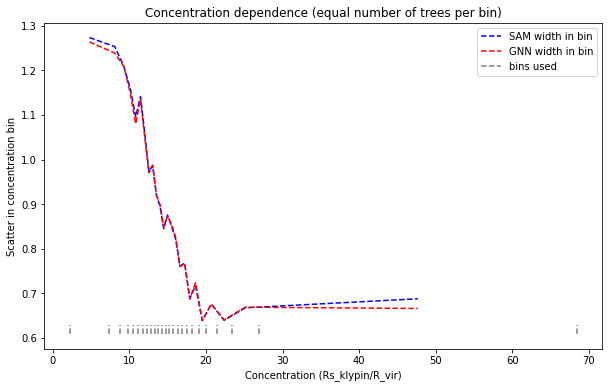

In [21]:
fig, ax =plt.subplots(ncols=1,nrows=1, figsize=(10,6))
# ax=ax.flatten()
ax.vlines(edges, min(deltay)-0.03, min(deltay)-0.01, color='gray', linestyle='--', label='bins used')
ax.plot(centers, deltay, 'b--', label='SAM width in bin')
ax.plot(centers, deltapred, 'r--', label='GNN width in bin')
ax.set(xlabel=r'Concentration (Rs_klypin/R_vir)', ylabel=r'Scatter in concentration bin', 
       title='Concentration dependence (equal number of trees per bin)')
ax.legend()

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


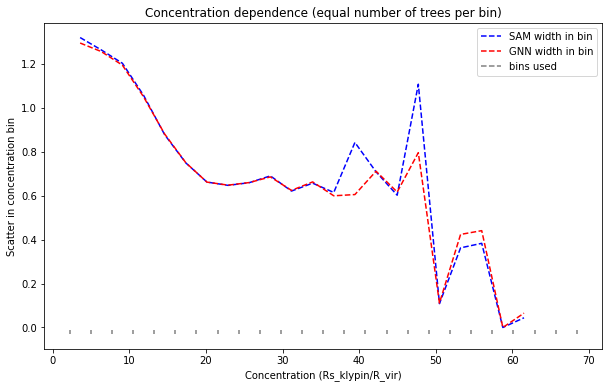

In [22]:
edges=np.linspace(min(Y), max(Y), nbins)
centers=(edges[:-1]+edges[1:])/2
deltay=[]
deltapred=[]

for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<Y,edges[i+1]>=Y)
    deltay.append(np.std(ys[mask]-np.mean(ys[mask])))
    deltapred.append(np.std(pred[mask]-np.mean(pred[mask])))
fig, ax =plt.subplots(ncols=1,nrows=1, figsize=(10,6))
# ax=ax.flatten()
ax.vlines(edges, min(deltay)-0.03, min(deltay)-0.01, color='gray', linestyle='--', label='bins used')
ax.plot(centers, deltay, 'b--', label='SAM width in bin')
ax.plot(centers, deltapred, 'r--', label='GNN width in bin')
ax.set(xlabel=r'Concentration (Rs_klypin/R_vir)', ylabel=r'Scatter in concentration bin', 
       title='Concentration dependence (equal number of trees per bin)')
ax.legend()